Create a conda environment to work with the data. Activate the environment and install NCBI's SRA toolkit

In [2]:
%%bash

# navigate to your working directory. Likely /mnt/c/Users/username/Documents/pop_genomics/
# cd /mnt/c/Users/username/Documents/pop_genomics/

# raise the hierarchy of the bioconda channel. Adds the channel to the list and places it first
conda config --add channels bioconda

# create the environment
conda create -n popgen fastp matplotlib numpy pandas jupyter snakemake scipy

# activate the environment
conda activate popgen

# maybe not the apt-get
# sudo apt-get update
# sudo apt-get install libgsl-dev

# install other packages
conda install bioconda::htslib
conda install bioconda::vcftools
conda install bwa picard
conda install -c conda-forge samtools
conda install -c bioconda gatk4


# installing sra-toolkit
mkdir software
cd software

# sra-toolkit for Ubuntu subsystems and Linux (you are running jobs from Linux
wget https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/3.0.10/sratoolkit.3.0.10-ubuntu64.tar.gz

# untar and uncompress
tar xvzf sratoolkit.3.0.10-ubuntu64.tar.gz
cd ../
FASTDUMP="${PWD}/software/sratoolkit.3.0.10-ubuntu64/bin/fastq-dump"

# test
$FASTDUMP --help


popgen_heliconius.ipynb
sratoolkit.3.0.10-ubuntu64
sratoolkit.3.0.10-ubuntu64.tar.gz


In [2]:
%%bash
# create a txt file with the accession numbers
# the file SraRunInfo.txt contains information of the SRA accessions we will use
# the first column is the accession number

ls
echo -e "\n\nPrinting Accession number and Species\n\n"
cat SraRunInfo.txt | cut -f1,29

# to skip the first line of the file:
echo -e "\n\nPrinting Accession number and Species\nskipping row 1\n\n"

tail -n +2 SraRunInfo.txt | cut -f1,29


GCA_000313835.2_ASM31383v2_assembly_stats.txt
GCA_000313835.2_ASM31383v2_genomic.dict
GCA_000313835.2_ASM31383v2_genomic.fna
GCA_000313835.2_ASM31383v2_genomic.fna.amb
GCA_000313835.2_ASM31383v2_genomic.fna.ann
GCA_000313835.2_ASM31383v2_genomic.fna.bwt
GCA_000313835.2_ASM31383v2_genomic.fna.fai
GCA_000313835.2_ASM31383v2_genomic.fna.pac
GCA_000313835.2_ASM31383v2_genomic.fna.sa
GCA_000313835.2_ASM31383v2_genomic.gbff.gz
Hahn, Matthew William - Molecular population genetics-Oxford University Press (2018).pdf
HsaraChr15.fasta
HsaraChr18.fasta
Snakefile
SnakefileClean
SraRunInfo.txt
Supp_Table_S1.pdf
accession_list.txt
chr15.delta
chr15_Hmmscaffolds.txt
chr15_aln.txt
chr18.delta
chr18_Hmmscaffolds.txt
chr18_aln.txt
clean
fastp.html
fastp.json
popgen_heliconius.ipynb
raw
software
speciation_heliconius.pdf


Printing Accession number and Species


Run	ScientificName
ERR260279	Heliconius melpomene rosina
ERR260280	Heliconius melpomene rosina
ERR260285	Heliconius melpomene melpomene
ERR26028

In [10]:
%%bash

# create the file `accession_list.txt`
tail -n +2 SraRunInfo.txt | cut -f1 > accession_list.txt

# print first 10
head accession_list.txt

ERR260279
ERR260280
ERR260285
ERR260286
ERR260289
ERR260290
ERR260293
ERR260294
ERR260297
ERR260298


In [ ]:
%%bash

# create folders
mkdir raw clean

# snakemake script to download the SRA data, remove adapters, and remove polyX

# create a file with
# nano Snakefile

# copy paste the following:

# Define the path variable
FASTDUMP="${PWD}/software/sratoolkit.3.0.10-ubuntu64/bin/fastq-dump"

rule all:
    input:
        expand("clean/{sample}_R1.fastq.gz", sample=[line.strip() for line in open("accession_list.txt")]),
        expand("clean/{sample}_R2.fastq.gz", sample=[line.strip() for line in open("accession_list.txt")])

rule download_fastq:
    output:
        "raw/{sample}_R1.fastq.gz",
        "raw/{sample}_R2.fastq.gz"
    params:
        sample="{sample}"
    shell:
        """
        {FASTDUMP} {params.sample} --split-files --outdir raw/
        gzip raw/{params.sample}_1.fastq
        gzip raw/{params.sample}_2.fastq
        mv raw/{params.sample}_1.fastq.gz {output[0]}
        mv raw/{params.sample}_2.fastq.gz {output[1]}
        """

rule trim_fastq:
    input:
        r1="raw/{sample}_R1.fastq.gz",
        r2="raw/{sample}_R2.fastq.gz"
    output:
        "clean/{sample}_R1.fastq.gz",
        "clean/{sample}_R2.fastq.gz",
        "clean/{sample}.out"
    params:
        sample="{sample}"
    shell:
        "fastp -i {input.r1} -I {input.r2} -o {output[0]} -O {output[1]} --detect_adapter_for_pe --trim_poly_g -h {output[]}"


In [ ]:
%%bash

# run snakemake
snakemake --cores 4

In [3]:
%%bash

# create bwa index for the reference assembly
# this needs to be done once only

# create index with BWA
bwa index Hmmref.fasta

# create fasta.fai index with samtools
samtools faidx Hmmref.fasta

# create sequence dictionary with picard
picard CreateSequenceDictionary R=Hmmref.fasta O=Hmmref.dict

[bwa_index] Pack FASTA... 0.01 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 0.23 seconds elapse.
[bwa_index] Update BWT... 0.01 sec
[bwa_index] Pack forward-only FASTA... 0.01 sec
[bwa_index] Construct SA from BWT and Occ... 0.09 sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa index Hmmref.fasta
[main] Real time: 0.392 sec; CPU: 0.340 sec
/home/mftorres/anaconda3/envs/popgen/bin/picard: line 5: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8): No such file or directory
INFO	2024-02-18 07:43:47	CreateSequenceDictionary	

********** NOTE: Picard's command line syntax is changing.
**********
********** For more information, please see:
********** https://github.com/broadinstitute/picard/wiki/Command-Line-Syntax-Transition-For-Users-(Pre-Transition)
**********
********** The command line looks like this in the new syntax:
**********
**********    CreateSequenceDictionary -R Hmmref.fasta -O Hmmref.dict
**********


07:43:47.725 INFO  NativeLibraryLoade

In [4]:
%%bash

ls

GCA_000313835.2_ASM31383v2_assembly_stats.txt
GCA_000313835.2_ASM31383v2_genomic.fna
GCA_000313835.2_ASM31383v2_genomic.gbff.gz
GCA_000313835_SL.fna
Hahn, Matthew William - Molecular population genetics-Oxford University Press (2018).pdf
Hmmref.dict
Hmmref.fasta
Hmmref.fasta.amb
Hmmref.fasta.ann
Hmmref.fasta.bwt
Hmmref.fasta.fai
Hmmref.fasta.pac
Hmmref.fasta.sa
HsaraChr15.fasta
HsaraChr18.fasta
Snakefile
SnakefileClean
SraRunInfo.txt
Supp_Table_S1.pdf
accession_list.txt
chr15.delta
chr15_Hmmscaffolds.fasta
chr15_Hmmscaffolds.txt
chr15_aln.txt
chr18.delta
chr18_Hmmscaffolds.fasta
chr18_Hmmscaffolds.txt
chr18_aln.txt
clean
fastp.html
fastp.json
popgen_heliconius.ipynb
raw
software
speciation_heliconius.pdf


In [ ]:
%%bash

#nano Snakefile

# map to reference and generate VCF

rule all:
    input:
        expand("clean/{sample}_sort.bam", sample=[line.strip() for line in open("accession_list.txt")]),
        expand("clean/{sample}_sort.bam.bai", sample=[line.strip() for line in open("accession_list.txt")]),
        expand("clean/{sample}_sort.flagstat", sample=[line.strip() for line in open("accession_list.txt")]),

rule map_fastq:
    input:
        "clean/{sample}_R1.fastq.gz",
        "clean/{sample}_R2.fastq.gz"
    output:
        "clean/{sample}_sort.bam",
        "clean/{sample}_sort.bam.bai",
        "clean/{sample}_sort.flagstat"
    params:
        RG=lambda wildcards: f"@RG\\tID:{wildcards.sample}\\tSM:{wildcards.sample}\\tLB:{wildcards.sample}\\tPL:ILLUMINA",
        REF="./Hmmref.fasta"
    shell:
        """
        bwa mem -M -t 8 -R '{params.RG}' {params.REF} {input[0]} {input[1]} | samtools view -@ 8 -b -F 4 | samtools sort -@ 8 - > {output[0]}
        samtools index {output[0]}
        samtools flagstat {output[0]} > {output[2]}
        """
        

In [ ]:
REF="./Hmmref.fasta"

while IFS= read -r line; do
    echo $line;
    bwa mem -M -t 8 -R "@RG\tID:${line}\tSM:${line}\tLB:${line}\tPL:ILLUMINA" $REF clean/${line}_R1.fastq.gz clean/${line}_R2.fastq.gz | \
    samtools view -@ 8 -b -F 4 | \
    samtools sort -@ 8 - > clean/${line}_sort.bam;
    wait;
    samtools index clean/${line}_sort.bam;
    wait;
    samtools flagstat clean/${line}_sort.bam > clean/${line}_sort.flagstat;
    wait;
done < accession_list.txt

In [ ]:
# get the number and percentage of mapped reads:
grep 'mapped (' clean/*flagstat

In [ ]:
%%bash
# mark duplicates

while IFS= read -r line || [[ -n "$line" ]]; do
    echo $line;
    picard MarkDuplicates \
    I=clean/${line}_sort.bam \
    O=clean/"${line}"_sort.mkd.bam \
    M=clean/"${line}".mkd.stats;
    wait;
done < accession_list.txt

In [ ]:
%%bash

# check percentage of duplication
grep -A 1 'PERCENT_DUPLICATION' clean/*stats | cut -f9

In [ ]:
# calling variants

conda create -n gatk37 gatk=3.7
conda activate gatk37
conda install samtools

cd ~/anaconda3/envs/gatk37/lib/
ln -s libcrypto.so.1.1 libcrypto.so.1.0.0


# you need to download and register this version
https://console.cloud.google.com/storage/browser/gatk-software/package-archive/gatk;tab=objects?pli=1&prefix=&forceOnObjectsSortingFiltering=false

# move the file to ./software/
cd software/

tar xvf package-archive_gatk_GenomeAnalysisTK-3.7-0-gcfedb67.tar
gatk-register GenomeAnalysisTK.jar

# test
gatk -T HaplotypeCaller --help

In [ ]:
# create an index for the bam
# then call gVCF

cd ../

REF="./Hmmref.fasta"
mkdir called

while IFS= read -r line; do
    echo $line;
    samtools index clean/"${line}"_sort.mkd.bam;
    wait;
    gatk -T HaplotypeCaller \
    -R $REF \
    -I clean/"${line}"_sort.mkd.bam \
    -o called/"${line}".g.vcf.gz \
    -ERC GVCF \
    -nct 8 \
    --pcr_indel_model NONE \
    --minPruning 10;
    wait;
done < accession_list.txt

In [ ]:
# joint genotyping
# back to gatk4

conda deactivate; conda activate popgen

# create a list of intervals
grep '>' Hmmref.fasta | sed 's/>//g' | cut -f1 -d" " > Hmm.intervals

# genotype

vcf_list=$(for i in called/*g.vcf.gz; do (echo "-V $i"); done)

# genomicsdb-workspace-path creates a new database
# use --genomicsdb-update-workspace-path to update the database

gatk GenomicsDBImport \
    $vcf_list \
    --genomicsdb-workspace-path Heliconius \
    --intervals Hmm.intervals \
    --reader-threads 8 $2> Heliconius.out

# if you encounter an error with the intervals ("only accepts one") try:
# conda update -n base -c defaults conda
# conda update gatk4

REF="./Hmmref.fasta"

# now, do the joint genotyping
# try running it without --allow-old-rms-mapping-quality-annotation-data
# if it failes add the argument --allow-old-rms-mapping-quality-annotation-data
gatk GenotypeGVCFs \
    -R $REF \
    -V gendb://Heliconius \
    -O called/HeliconiusJointRaw.vcf.gz \
    --allow-old-rms-mapping-quality-annotation-data \
    --heterozygosity 0.01 $2> called/HeliconiusJointRaw.out
 

In [ ]:
# filter low quality variants!

# check GATK's filtering arguments
zcat called/HeliconiusJointRaw.vcf.gz | grep 'INFO'

REF="./Hmmref.fasta"

# now, create a VCF with variants only (from the gVCF)
gatk SelectVariants \
   -R $REF \
   -V called/HeliconiusJointRaw.vcf.gz \
   --select-type-to-include SNP \
   -O called/HeliconiusJointRaw.SNPs.vcf.gz

# get the scores for INFO parameters across all SNPs to plot them:

for args in QD FS MQ MQRankSum ReadPosRankSum SOR; do
    vcftools --gzvcf called/HeliconiusJointRaw.SNPs.vcf.gz \
    --get-INFO $args --out called/raw.snps."${args}";
done

In [7]:
# check distributions
# load the libraries required
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import time
import glob
from os import path
# from scipy.stats import gaussian_kde
import re

%matplotlib inline

# image ploting
from matplotlib.lines import Line2D

# indicate the path and file extensions
path = os.getcwd()
ext = 'called/raw.snps.*INFO'

# create an empty dictionary to store the name of the INFO field and the INFO data
data ={}

for filename in glob.glob(os.path.join(path,'%s'%(ext))):
    
    # create empty list to store data per INFO field
    info = []
    
    # get the name of the INFO field from the file name
    kk = filename.split('/')[-1].split('.')[-2]
    print(kk)
    
    # open the files and extract the fourth column with the values in the INFO field
    with open(filename, 'r') as file:
        # skip the line with headers
        next(file)
        
        for line in file:
            # get only the fourth column
            ll = line.split('\t')[4].strip('\n').replace('?','')
            
            # append the value to the list
            info.append(ll)
            
        # pass the Key value (kk; the INFO field name) and Value value (list of values) to the dictionary
        data[kk] = info
# check
print(data['FS'])

FS
MQ
MQRankSum
QD
ReadPosRankSum
SOR
['0.000', '4.044', '9.544', '7.969', '3.738', '0.000', '0.000', '0.000', '0.000', '4.313', '0.918', '4.317', '4.324', '4.325', '0.535', '11.831', '1.661', '0.000', '0.000', '18.713', '2.170', '5.203', '0.000', '2.237', '23.487', '38.429', '2.148', '21.379', '3.381', '13.134', '24.624', '20.404', '1.910', '7.616', '11.857', '12.523', '4.483', '11.921', '3.099', '0.000', '5.382', '14.334', '10.832', '17.234', '3.368', '2.991', '4.024', '1.072', '2.645', '1.811', '0.861', '2.381', '2.031', '10.590', '38.107', '1.333', '0.773', '3.651', '1.313', '1.580', '6.375', '0.000', '0.000', '0.570', '0.000', '0.629', '5.744', '0.000', '2.489', '9.391', '0.643', '1.414', '8.118', '0.000', '7.106', '2.122', '1.102', '0.000', '2.529', '37.382', '39.301', '7.581', '0.662', '34.033', '0.649', '3.230', '5.276', '8.212', '6.982', '3.376', '5.109', '0.000', '2.764', '0.627', '14.556', '2.407', '0.000', '0.670', '2.848', '9.361', '0.520', '9.345', '0.000', '0.000', '4.13

In [8]:
print(float(max(data['MQRankSum']))/10)

0.999


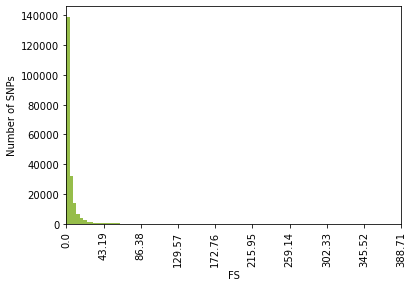

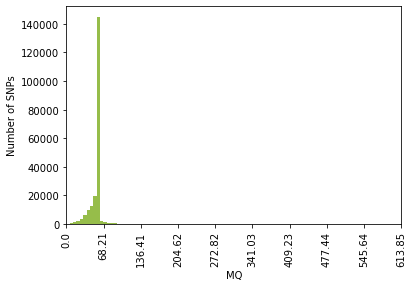

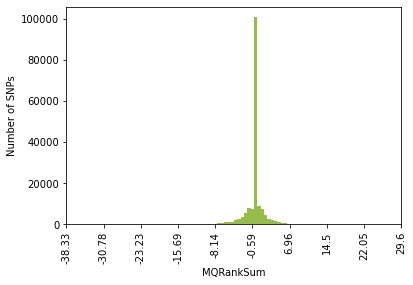

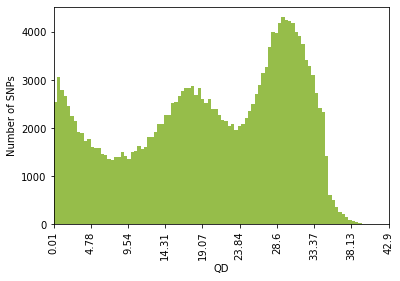

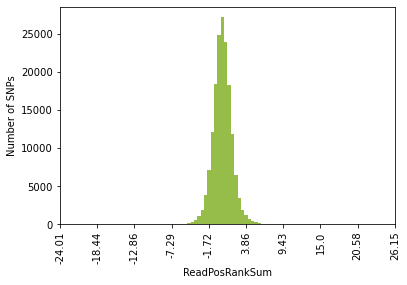

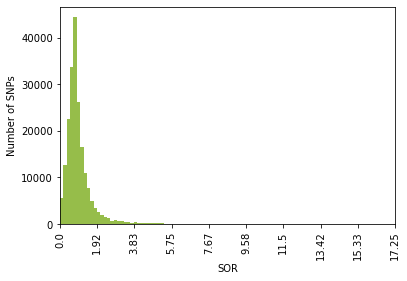

In [34]:
col = '#96bd4a'
for key,value in data.items():
    
    vv = [round(float(x), 2) for x in value if x != '']
    
    # initiate the figure and axis
    fig,ax = plt.subplots(figsize = (6,4), facecolor = 'w')
    
    ax.set_xlim(min(vv), max(vv))

    # create the histogram
    ax.hist(sorted(vv), color = col, bins = 100)
    
    # set the xaxis tick lables
    ticks = [round(float(x), 2) for x in np.linspace(min(vv),max(vv),10)]
    # labels and positions are the same
#     plt.xticks(['%.3f'%(float(x)) for x in ticks], ticks, rotation = 90)
    plt.xticks(ticks, ticks, rotation = 90)

    plt.ylabel('Number of SNPs')
    plt.xlabel('%s'%(key))
    
    plt.show()


In [ ]:
# Mark filters
REF="./Hmmref.fasta"

gatk VariantFiltration \
    -R $REF \
    -V called/HeliconiusJoint.gatkfilt.vcf.gz \
    --filter-expression "MQ < 50.0" --filter-name "badMQ" \
    --filter-expression "QD < 2.0" --filter-name "badQD" \
    --filter-expression "FS > 60.0" --filter-name "badFS" \
    --filter-expression "SOR > 3.0" --filter-name "badSOR" \
    --filter-expression "MQRankSum < -12.5" --filter-name "badMQRankSum" \
    --filter-expression "ReadPosRankSum < -8.0" --filter-name "badReadPosRankSum" \
    --filter-expression "DP < 409.0" --filter-name "lowCov" \
    --filter-expression "DP > 1636.0" --filter-name "highCov" \
    -O called/HeliconiusJoint.gatkfilt.vcf.gz

# filter
gatk SelectVariants \
    -R $REF \
    -V called/HeliconiusJoint.gatkfilt.vcf.gz \
    --exclude-filtered true \
    -O called/HeliconiusJoint.gatkpassed.SNPs.vcf.gz

# # get the scores for INFO parameters across all SNPs to plot them:

for args in QD FS MQ MQRankSum ReadPosRankSum SOR; do
    vcftools --gzvcf called/HeliconiusJoint.gatkpassed.SNPs.vcf.gz \
    --get-INFO $args --out called/passed.snps."${args}";
done

In [30]:
path = os.getcwd()
ext = 'called/passed.snps.*INFO'

cleandata ={}

for filename in glob.glob(os.path.join(path,'%s'%(ext))):
    info = []
    kk = filename.split('/')[-1].split('.')[-2]
    print(kk)
    with open(filename, 'r') as file:
        next(file)
        
        for line in file:
            ll = line.split('\t')[4].strip('\n').replace('?','')
            info.append(ll)
        cleandata[kk] = info
print(cleandata['FS'])

FS
MQ
MQRankSum
QD
ReadPosRankSum
SOR
['0.000', '0.000', '0.000', '10.772', '0.000', '0.000', '9.879', '0.000', '0.000', '0.836', '0.000', '8.195', '2.920', '3.130', '1.489', '6.917', '4.844', '2.991', '2.980', '25.207', '2.927', '4.400', '12.302', '0.000', '5.768', '0.000', '0.000', '11.623', '0.000', '1.157', '2.623', '0.989', '0.900', '1.910', '0.000', '4.828', '2.524', '0.000', '0.000', '5.015', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '3.544', '14.215', '0.000', '0.000', '0.876', '2.320', '7.644', '0.000', '8.796', '1.957', '1.957', '4.242', '0.000', '17.232', '0.000', '0.000', '8.506', '4.541', '0.000', '1.937', '1.451', '0.000', '2.747', '1.077', '5.602', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '1.632', '0.000', '0.000', '1.179', '0.000', '0.000', '4.013', '0.000', '0.000', '1.550', '1.808', '1.808', '2.249', '5.612', '0.000', '0.000', '0.000', '5.727', '0.000', '3.358', '7.583', '4.224', '4.584', '0.000', '0.000', '0.000', '

0 FS
1 MQ
2 MQRankSum
3 QD
4 ReadPosRankSum
5 SOR


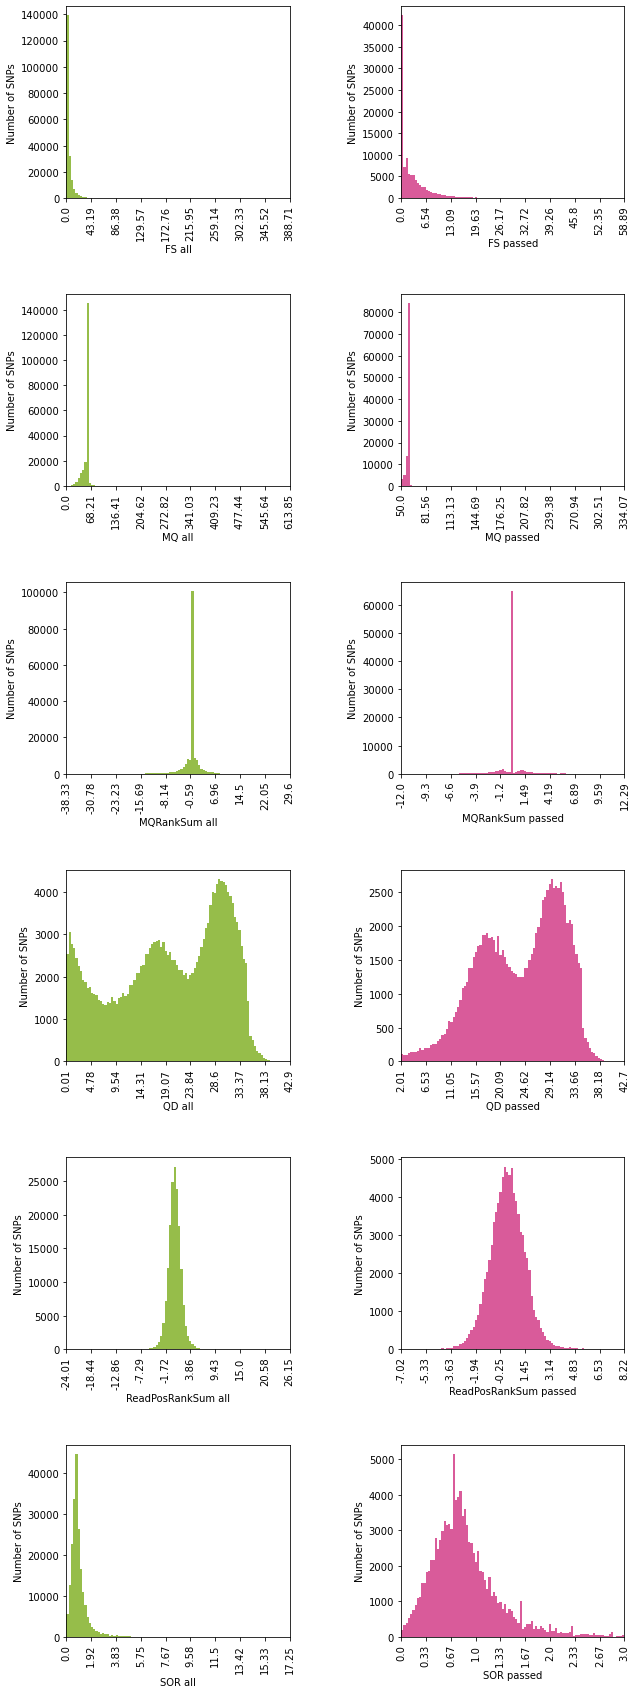

In [35]:
from matplotlib import gridspec


plt.figure(figsize=(5*2,5*6),facecolor='w')
G = gridspec.GridSpec(6,2,hspace=0.5,wspace=0.5)

# keys in data and clean data should be the same
for y,key in enumerate(data.keys()):
    print(y,key)
    
    ax = plt.subplot(G[y,0])
    col = '#96bd4a'
    vv = [round(float(x), 2) for x in data[key] if x != '']
    ax.set_xlim(min(vv), max(vv))
    ax.hist(sorted(vv), color = col, bins = 100)
    ticks = [round(float(x), 2) for x in np.linspace(min(vv),max(vv),10)]
    plt.xticks(ticks, ticks, rotation = 90)
    plt.ylabel('Number of SNPs')
    plt.xlabel('%s all'%(key))
    
    ax = plt.subplot(G[y,1])
    col = '#d95b9a'
    vv = [round(float(x), 2) for x in cleandata[key] if x != '']
    ax.set_xlim(min(vv), max(vv))
    ax.hist(sorted(vv), color = col, bins = 100)
    ticks = [round(float(x), 2) for x in np.linspace(min(vv),max(vv),10)]
    plt.xticks(ticks, ticks, rotation = 90)
    plt.ylabel('Number of SNPs')
    plt.xlabel('%s passed'%(key))
    
plt.show()

In [ ]:
%%bash
# coverage
vcftools --gzvcf called/HeliconiusJoint.gatkpassed.SNPs.vcf.gz --depth --out called/per_ind

# Depth per site summed across all individuals:
vcftools --gzvcf called/HeliconiusJoint.gatkpassed.SNPs.vcf.gz --site-depth --out called/per_site

# Mean depth per site summed across all individuals:
vcftools --gzvcf called/HeliconiusJoint.gatkpassed.SNPs.vcf.gz --site-mean-depth --out called/mean_per_site

In [44]:
path = os.getcwd()
ext = 'called/*depth*'

coverage ={}

for filename in glob.glob(os.path.join(path,'%s'%(ext))):
    print(filename)
    info = []
    info2 =[]
    kk = filename.split('/')[-1].split('.')[0]
    print(kk)
    with open(filename, 'r') as file:
        next(file)
        if kk != 'per_ind':
            for line in file:
                ll = line.split('\t')[2].strip('\n').replace('?','') # MEAN_DEPTH or SUM_DEPTH
                nn = line.split('\t')[3].strip('\n').replace('?','') # VAR_DEPTH or SUMSQ_DEPTH
                info.append(ll)
                info2.append(nn)
            coverage['%s_col2'%(kk)] = info
            coverage['%s_col3'%(kk)] = info2
        else:
            for line in file:
                ll = line.split('\t')[2].strip('\n').replace('?','')
                info.append(ll)
            coverage[kk] = info

/mnt/c/Users/mftor/Documents/pop_genomics/called/mean_per_site.ldepth.mean
mean_per_site
/mnt/c/Users/mftor/Documents/pop_genomics/called/per_ind.idepth
per_ind
/mnt/c/Users/mftor/Documents/pop_genomics/called/per_site.ldepth
per_site


In [47]:
print(coverage.keys())
print(coverage['per_ind'])

dict_keys(['mean_per_site_col2', 'mean_per_site_col3', 'per_ind', 'per_site_col2', 'per_site_col3'])
['48.5031', '67.8258', '61.067', '15.8587', '30.6428', '52.8503', '46.0274', '36.9183', '76.7179', '92.5982', '36.922', '34.4136', '30.1909', '34.0023']


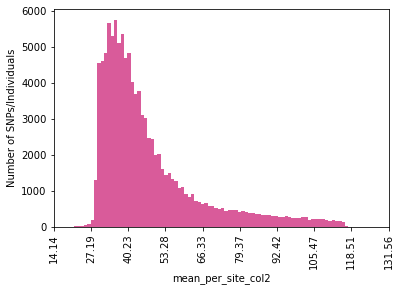

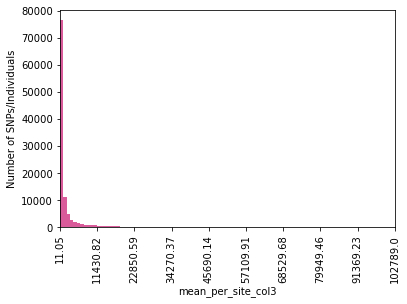

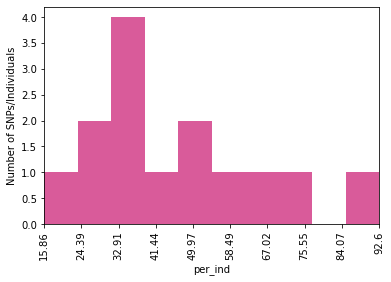

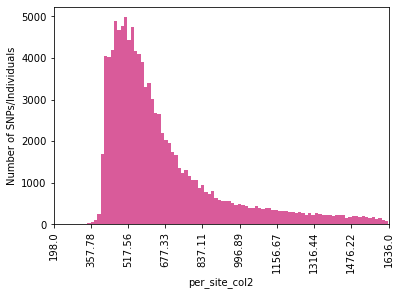

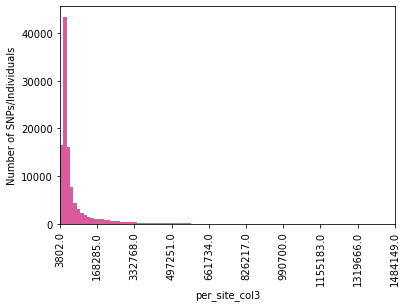

In [48]:
col = '#d95b9a'
for key,value in coverage.items():
    vv = [round(float(x), 2) for x in value if x != '']

    fig,ax = plt.subplots(figsize = (6,4), facecolor = 'w')
    ax.set_xlim(min(vv), max(vv))
    ax.hist(sorted(vv), color = col, bins = 100 if key != 'per_ind' else 10)
    
    # set the xaxis tick lables
    ticks = [round(float(x), 2) for x in np.linspace(min(vv),max(vv),10)]
    plt.xticks(ticks, ticks, rotation = 90)

    plt.ylabel('Number of SNPs/Individuals')
    plt.xlabel('%s'%(key))
    
    plt.show()

In [ ]:
# it is best to filter out depth (read coverage).
# Often, those SNPs come from repetitive regions that are difficult to resolve in the assembly
# and we cannot know the true homology and thus, we cannot use it for population genomics
# above, cols3 correspond to variance and sumsqr (dispersion measures)

# Class break

In [ ]:
%%bash

# create a file with info about the individuals
# if you have a VCF, you can do:
# grep "^#CHROM" your_file.vcf | cut -f10-

# for a compressed VCF (vcf.gz)
zcat called/HeliconiusJoint.gatkpassed.SNPs.vcf.gz | grep '#CHR' | cut -f10- | perl -pe 's/\t/./g' > temp.ind

In [ ]:
# detecting contamination by checking allelic balance at heterozygote sites
# looking for contamination between samples
# this is not working, I need to fix it

# open R
# go to your working directory
setwd("/path/to/your/new/directory")

# print working directory
getwd()

# create object with the VCF
base <- 'called/HeliconiusJoint.gatkpassed.SNPs.vcf.gz'

xmaxx<-as.double(500);

# creates temp file with individuals information
inds <- as.character(read.table("./temp.ind",sep=".")$V1);

# creates a PDF for the plots
pdf(paste(base,"hetIndStats.pdf",sep="."),width=10,height=5);

# colour palette for plotting
rcbpal<-c("#ffeda0","#fed976","#feb24c","#fd8d3c","#fc4e2a","#e31a1c","#bd0026","#800026");
par(mfrow=c(1,2));rf<-colorRampPalette((rcbpal));r<-rf(12);

for(i in inds){
    if(file.exists(paste("hets",i,sep="."))){
        if(file.info(paste("hets",i,sep="."))$size>0){
            d<-read.table(paste("hets",i,sep="."),sep=",")
            d<-cbind(d,max=apply(d,1,max),min=apply(d,1,min));
            d<-cbind(d,minreadprop=d$min/(d$min+d$max),depth=d$min+d$max);
            x.bin<-seq(floor(min(d$depth,na.rm=T)),ceiling(max(d$depth,na.rm=T)),length=ceiling(max(d$depth,na.rm=T))-floor(min(d$depth,na.rm=T))+1);
            y.bin<-seq(floor(min(d$min,na.rm=T)),ceiling(max(d$min,na.rm=T)),length=ceiling(max(d$min,na.rm=T))-floor(min(d$min,na.rm=T))+1);
            freq<-as.data.frame(table(findInterval(d$depth,x.bin),findInterval(d$min,y.bin)));
            freq[,1] <- as.numeric(as.character(freq[,1]));
            freq[,2] <- as.numeric(as.character(freq[,2]));
            freq2D<-matrix(0,nrow=length(x.bin),ncol=length(y.bin));
            freq2D[cbind(freq[,1], freq[,2])] <- freq[,3];
            if(xmaxx==0) xmaxx=max(x.bin,na.rm=T);
            image(x.bin,y.bin,log10(freq2D),col=r,breaks = seq(0,max(log10(freq2D),na.rm=T),length.out=length(r)+1),
            main=paste(i,sep=""),xlab="DP",ylab="Reads minor alleles",xlim=c(0,xmaxx),ylim=c(0,max(x.bin,na.rm=T)/2));
            barval<-round(10^(seq(0,max(log10(freq2D),na.rm=T),length.out = length(r)+1)));
            legend("topleft",legend=rev(barval[round(seq(2,length(barval),length.out = length(r)))]),
            fill=rev(r[round(seq(1,length(barval[-1]),length.out = length(r)))]),bty="n",ncol=3,title="heterozygous genotypes count");
            abline(0,1/2);abline(0,1/5,col="#00FF0088",lty=1);abline(0,3/10,col="#0000FF88",lty=1);
            legend("left",c("50:50 both alleles","70:30 common:rare","80:20"),
            lwd=1,lty=c(1,1,1),col=c(1,"#0000FF88","#00FF0088"),bty="n",cex=0.8);
            hist(d$minreadprop,breaks=seq(0,0.5,by=0.02),col=1,xlim=c(0,0.5),
            xlab="Proportion minor allele reads",main=paste(i,sep=""));
            abline(v=0.2,col="#00FF0088",lty=1);abline(v=0.3,col="#0000FF88",lty=1)
            }
        }
    }
 

In [ ]:
# running simulations
# create environment first

conda config --add channels conda-forge
conda create -n msprime-env python=3.7
conda activate msprime-env

# check you have pip
python3 -m pip --version

# install msprime
python3 -m pip install msprime

# check version
msp --version

mkdir msprime
cd msprime

# create a script to generate simulated populations
nano msprime_sym.py

############## add the code below
# msprime_sym.py
import msprime
import argparse
from datetime import datetime

def simulate_ancestry(migration_rate):
    # simulate two populations
    demography = msprime.Demography()
    demography.add_population(name = "sim0", initial_size = 1000)
    demography.add_population(name = "sim1", initial_size = 1000)
    demography.set_symmetric_migration_rate(populations = ["sim0", "sim1"], rate = migration_rate)

    # Run the simulation  
    ts = msprime.sim_ancestry(
        samples = {"sim0": 50, "sim1": 50},  # 50 samples from each population
        demography = demography,
        random_seed = 42,
        sequence_length = 1.6e6, # 135304 Chr15 + 1540240 Chr18 = 1675544 aprox 1.6e6
        recombination_rate = 2.9e-8 # recombinations per base per site per generation assuming lack of variance across genome (Martin et al. 2011; H. melpomene)
    )
    return ts

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description = "msprime to simulate two populations with migration rate X")
    parser.add_argument("migration_rate", type = float, help="Symatric migration rate between populations as a fraction (e.g. 0.01 for 1%).")

    args = parser.parse_args()

    # Run simulation
    ts = simulate_ancestry(args.migration_rate)
    
    mts = msprime.sim_mutations(ts, rate = 2.9e-8, random_seed = 42)
    
    # Generate a uniquely named output file
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = "msp_{}.hdf5".format(args.migration_rate)
    ts.dump(filename)
    print("Output saved to {}".format(filename))
    print(timestamp)
    
    # Export the simulated genotypes based on the simulation to a VCF file
    with open("msp_{}.vcf".format(args.migration_rate), "w") as vcf_file:
        mts.write_vcf(vcf_file)

# run as
# python3 msprime_sym.py 0.01

# You can run a loop with different migration rates like this:
conda deactivate; conda activate msprime-env

start=0.01
end=0.51
step=0.1

for i in $(seq $start $step $end); do
    python3 msprime_sym.py $i
done

# before running faststructure, we need to change the name of one population as it doesnt like names ending in zero
sed -i 's/tsk_0/tsk_a/g' *vcf

The hdf5 file contains:
    
Tree sequences: Representations of the simulated genealogies across different genomic regions.
Population metadata: Information about the simulated populations, such as size, growth rates, and migration rates.
Genetic variation: Data on mutations and genetic variants generated during the simulation.
Sample information: Details about the sampled individuals or genomes, including their population affiliations.

The VCF is similar to other VCFs that we know

In [ ]:
%%bash

conda deactivate; conda activate angsd

# Run fastsctructure for the simulated VCF
# run it within msprime's folder
for i in *vcf; do
    echo $i
    plink --vcf $i --make-bed \
      --out "${i%%.vcf*}".bed \
      --allow-extra-chr \
      --biallelic-only \
      --threads 8;
    wait;
done

mkdir simstructure

for i in *vcf; do
    echo $i;
    for k in 1 2 3 4; do structure.py \
         -K $k \
         --input=${i%%.vcf*}.bed \
         --output=../simstructure/"${i%%.vcf*}"_fs.out \
         --tol=10e-6 \
         --prior=simple \
         --format=bed \
         --full \
         --seed=666;
         wait;
    done;
    wait;
    chooseK.py --input=../simstructure/"${i%%.vcf*}"_fs.out;
    wait;
done

cd ../simstructure

grep 'Marginal Likelihood' *log

msp_0.01_fs.out.2.log:Marginal Likelihood = -0.5858350433 --> ML
msp_0.01_fs.out.3.log:Marginal Likelihood = -0.6010170789
msp_0.01_fs.out.4.log:Marginal Likelihood = -0.6133536790
    
msp_0.11_fs.out.2.log:Marginal Likelihood = -0.5975533582
msp_0.11_fs.out.3.log:Marginal Likelihood = -0.6065797785
msp_0.11_fs.out.4.log:Marginal Likelihood = -0.6172373481
    
msp_0.21_fs.out.2.log:Marginal Likelihood = -0.5944356127
msp_0.21_fs.out.3.log:Marginal Likelihood = -0.6044793243
msp_0.21_fs.out.4.log:Marginal Likelihood = -0.6131639822
    
msp_0.31_fs.out.2.log:Marginal Likelihood = -0.5884776918
msp_0.31_fs.out.3.log:Marginal Likelihood = -0.5962314921
msp_0.31_fs.out.4.log:Marginal Likelihood = -0.6088601091
    
msp_0.41_fs.out.2.log:Marginal Likelihood = -0.6180458763
msp_0.41_fs.out.3.log:Marginal Likelihood = -0.6237770268
msp_0.41_fs.out.4.log:Marginal Likelihood = -0.6353133939
    
msp_0.51_fs.out.2.log:Marginal Likelihood = -0.6112893658
msp_0.51_fs.out.3.log:Marginal Likelihood = -0.6218982431
msp_0.51_fs.out.4.log:Marginal Likelihood = -0.6333610546

# Class break

In [ ]:
# Understand population structure
# first, the environment
conda create -n angsd angsd plink bcftools vcftoo
conda activate angsd
conda install bioconda::faststructure

mkdir structure
cp called/HeliconiusJoint.gatkpassed.SNPs.vcf.gz structure/HeliconiusJoint.gatkpassed.SNPs.vcf.gz

# Create a biallelic SNPs only BED file - something like coordinates that indicate where biallelic SNPs are
# biallelic only because must software/models are optimised for biallelic SNPs
# under the infinite site model, a site mutates once with no reversal, making sites effectively biallelic
# Plink prepares the bed files 


plink --vcf structure/HeliconiusJoint.gatkpassed.SNPs.vcf.gz --make-bed \
  --out structure/HeliconiusJoint.gatkpassed.SNPs.bed \
  --allow-extra-chr \
  --biallelic-only \
  --threads 8


for k in 2 3 4 5 6 7 8; do structure.py \
     -K $k \
     --input=structure/HeliconiusJoint.gatkpassed.SNPs.bed \
     --output=structure/fs.out \
     --tol=10e-6 \
     --prior=simple \
     --format=bed \
     --full \
     --seed=666; done
 
chooseK.py --input=structure/fs.out

# looks for the smallest value of K that captures the major structure in the data:
# Model complexity that maximizes marginal likelihood = 2
# Model components used to explain structure in data = 3
# Model components are the smallest number of these ancestral populations that can explain the observed genetic variation
# among the individuals sampled

grep 'Marginal Likelihood' structure/*log

# structure/fs.out.2.log:Marginal Likelihood = -0.7728594100 --> maximases marginal likelihood
# structure/fs.out.3.log:Marginal Likelihood = -0.7919308011
# structure/fs.out.4.log:Marginal Likelihood = -0.7919419291
# structure/fs.out.5.log:Marginal Likelihood = -0.7729154183
# structure/fs.out.6.log:Marginal Likelihood = -0.7919571921
# structure/fs.out.7.log:Marginal Likelihood = -0.7919619108
# structure/fs.out.8.log:Marginal Likelihood = -0.7729276830

In [32]:
%%bash

cut -f1,29 SraRunInfo.txt


Run	ScientificName
ERR260279	Heliconius melpomene rosina
ERR260280	Heliconius melpomene rosina
ERR260285	Heliconius melpomene melpomene
ERR260286	Heliconius melpomene melpomene
ERR260289	Heliconius melpomene amaryllis
ERR260290	Heliconius melpomene amaryllis
ERR260293	Heliconius melpomene aglaope
ERR260294	Heliconius melpomene aglaope
ERR260297	Heliconius cydno chioneus
ERR260298	Heliconius cydno chioneus
ERR260301	Heliconius timareta
ERR260302	Heliconius timareta
ERR260303	Heliconius pardalinus
ERR260304	Heliconius pardalinus sergestus


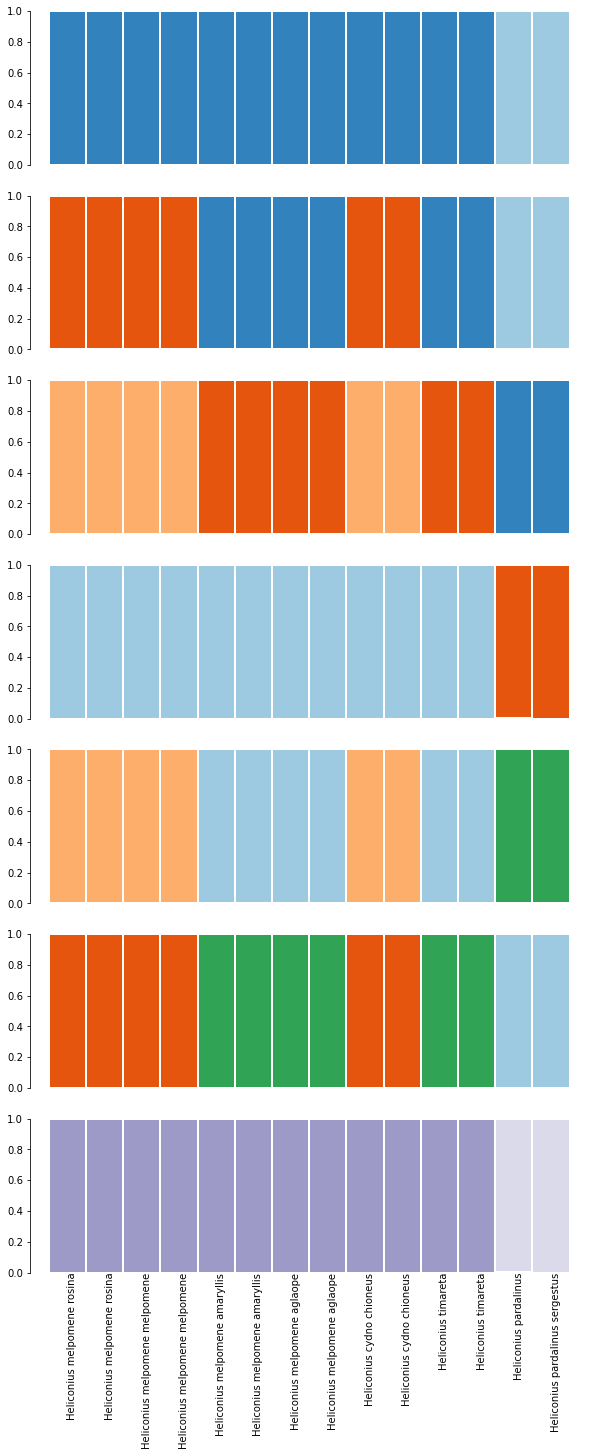

In [52]:
# plot the structure results
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import time
import glob
import os
from os import path
from matplotlib.patches import Polygon ## for polygons
from matplotlib import gridspec ## for composite figures

# read the file with population information, make it into a dictionary
samples = {}
with open('./SraRunInfo.txt') as file:
    next(file)
    for line in file:
#         print(line.split('\t')[0], line.split('\t')[28])
        samples[line.split('\t')[0]] = line.split('\t')[28]
        
# print(samples)

sample_VCForder = {}
with open('./temp.ind') as file:
    for line in file:
        temp = line.strip('\n').split('.')
#         print(temp)
        sample_VCForder = dict(zip(range(0,len(temp)), temp))
        
# print(sample_VCForder)
# print(samples[sample_VCForder[0]])

# # https://groups.google.com/g/structure-software/c/wiueM0yA3iE?pli=1
# # 2. MeanQ contains, as you correctly interpreted cluster membership coefficients per cluster.  It is a matrix of nrow(length(inds)) and ncol(indlabel+K).
# # 3. The meanP is a matrix of allele frequencies per locus per cluster.  Thus, nrow(length(loci)) x ncol(loclabel+K).

path = os.getcwd()
ext ='structure/*meanQ'

max_k = 9
fig,ax = plt.subplots(figsize = (10,30), facecolor = 'w')
G = gridspec.GridSpec(max_k, 1, hspace = 0.2, wspace = 2)#width_ratios=[0.08,1.1,2]

cmap = mpl.cm.tab20c
pop_list = ['k_%s'%(x+1) for x in range(0,max_k,1)]
col_list = [cmap(pop/max_k) for pop in range(0,max_k,1)]
pop_col_dict = dict(zip(pop_list,col_list))

for filename in glob.glob(os.path.join(path,'%s'%(ext))):
#     print(filename)
    knum = int(filename.split('.')[-2])
    results = pd.read_csv(filename, sep = '\s+', header = None, index_col = False,
                          names = ['k_%s'%(x+1) for x in range(0,knum,1)])#, names = ['k_%s'%(x+1) for x in range(0,knum,1)])
#     print(results.head(5))

    ax = plt.subplot(G[knum-1,0],facecolor = 'w')
    x = range(0,len(results),1)
    bottom = 0
    for i in range(0,knum,1):
            width = 1
            height = results['k_%s'%(i+1)]
            ax.bar(x, height, width, bottom, edgecolor = 'w', linewidth = 2, color = pop_col_dict['k_%s'%(i+1)])
            bottom = bottom + results['k_%s'%(i+1)]
    
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_xlim(-1, len(pop_list)+5)
    ax.set_ylim(0,1)
    [ax.spines[loc].set_visible(False) for loc in ['top','right','bottom']]
    
for key in sample_VCForder.keys(): 
    ax.text(x = key, y = 0, s = samples[sample_VCForder[key]], rotation = 90, va = 'top')

plt.show()


In [53]:
%%bash

# but for example, what are these numbers for k = 3?
less structure/fs.out.3.meanQ

0.000002  0.000004  0.999994
0.000002  0.000003  0.999994
0.000002  0.000003  0.999995
0.000002  0.000004  0.999994
0.999994  0.000003  0.000002
0.999994  0.000003  0.000002
0.999994  0.000003  0.000002
0.999994  0.000003  0.000002
0.000002  0.000003  0.999995
0.000002  0.000003  0.999995
0.998468  0.000003  0.001528
0.999995  0.000003  0.000002
0.000002  0.999997  0.000002
0.000002  0.999996  0.000002
